# EDA Notebook for EGX30 Market Data

This notebook performs exploratory data analysis on the EGX30 market dataset, including data loading, cleaning, quality checks, statistical analysis, and visualizations.

In [ ]:
# Standard library imports
import os
from pathlib import Path
import sys  

ROOT_DIR = Path().resolve().parents[1]
sys.path.append(str(ROOT_DIR))

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import patches
from scipy.stats import norm

# Local application imports
from config.paths import RAW_MARKET_FILE, EDA_OUTPUT_DIR

In [ ]:
# Data Loading
df = pd.read_csv(RAW_MARKET_FILE)

In [3]:
df = pd.read_csv(RAW_MARKET_FILE)

In [4]:
df.describe()

,open,high,low,close,volume
count,119031.000000,119031.000000,119031.000000,119031.000000,1.190310e+05
mean,11.502804,11.729259,11.314359,11.512884,3.922214e+06
std,18.154432,18.548458,17.890133,18.187768,1.289059e+07
min,0.065657,0.065685,0.065657,0.065685,0.000000e+00
25%,3.083377,3.140000,3.024415,3.083795,1.734601e+05
50%,6.200000,6.312000,6.083993,6.200000,8.952130e+05
75%,12.510000,12.780000,12.300000,12.520000,3.271324e+06
max,271.010000,276.000000,261.000000,271.010000,2.075677e+09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119031 entries, 0 to 119030
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    119031 non-null  object 
 1   symbol  119031 non-null  object 
 2   open    119031 non-null  float64
 3   high    119031 non-null  float64
 4   low     119031 non-null  float64
 5   close   119031 non-null  float64
 6   volume  119031 non-null  float64
 7   Ticker  119031 non-null  object 
dtypes: float64(5), object(3)
memory usage: 7.3+ MB


In [6]:
df.columns = df.columns.str.lower()

In [7]:
print(df["symbol"].unique())
df["symbol"].nunique()

['EGX:CIEB' 'EGX:ORHD' 'EGX:DOMT' 'EGX:CIRA' 'EGX:EAST' 'EGX:EGAL'
 'EGX:HELI' 'EGX:ABUK' 'EGX:SUGR' 'EGX:ADIB' 'EGX:MTIE' 'EGX:EXPA'
 'EGX:ORWE' 'EGX:MASR' 'EGX:EFIC' 'EGX:HRHO' 'EGX:AMOC' 'EGX:ETEL'
 'EGX:SWDY' 'EGX:TMGH' 'EGX:PHDC' 'EGX:BTFH' 'EGX:CCAP' 'EGX:JUFO'
 'EGX:COMI' 'EGX:ESRS' 'EGX:MFPC' 'EGX:ISPH' 'EGX:FWRY' 'EGX:EKHOA']


30

In [8]:
df.rename(columns={"price": "close"} , inplace=True)

In [9]:
df.shape


(119031, 8)

In [10]:
df.columns


Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'ticker'], dtype='object')

In [11]:
df.dtypes


date       object
symbol     object
open      float64
high      float64
low       float64
close     float64
volume    float64
ticker     object
dtype: object

In [12]:
df.head()


,date,symbol,open,high,low,close,volume,ticker
0,2001-05-15 10:00:00,EGX:CIEB,0.081230,0.081258,0.081230,0.081258,6.001330e+05,CIEB
1,2001-05-16 10:00:00,EGX:CIEB,0.081230,0.084031,0.081230,0.082183,7.354396e+05,CIEB
2,2001-05-16 10:00:00,EGX:ORHD,0.398725,0.398725,0.380764,0.396569,1.058569e+05,ORHD
3,2001-05-17 10:00:00,EGX:CIEB,0.084031,0.086272,0.084031,0.086132,1.082453e+06,CIEB
4,2001-05-20 10:00:00,EGX:CIEB,0.090334,0.090446,0.089633,0.090390,2.371614e+06,CIEB


In [13]:
df.tail()


,date,symbol,open,high,low,close,volume,ticker
119026,2026-02-19 10:00:00,EGX:ORWE,23.70,23.88,22.80,22.98,1575968.0,ORWE
119027,2026-02-19 10:00:00,EGX:PHDC,9.74,9.79,9.30,9.40,9905430.0,PHDC
119028,2026-02-19 10:00:00,EGX:SUGR,48.01,48.45,47.11,47.20,190126.0,SUGR
119029,2026-02-19 10:00:00,EGX:SWDY,83.49,84.80,80.02,80.75,1035574.0,SWDY
119030,2026-02-19 10:00:00,EGX:TMGH,96.37,97.39,91.55,91.55,2634503.0,TMGH


In [14]:
pd.api.types.is_datetime64_any_dtype(df["date"])

False

In [15]:
df["date"].is_monotonic_increasing

True

In [16]:
df["date"] = pd.to_datetime(df["date"])

In [17]:
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
missing_dates = full_range.difference(df['date'].dt.normalize().unique())

print(f"Number of missing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("First 5 missing dates:")
    print(missing_dates[:5])

Number of missing dates: 9047
First 5 missing dates:
DatetimeIndex(['2001-05-15 10:00:00', '2001-05-16 10:00:00',
               '2001-05-17 10:00:00', '2001-05-18 10:00:00',
               '2001-05-19 10:00:00'],
              dtype='datetime64[ns]', freq='D')


In [18]:
missing_dates_df = pd.DataFrame(missing_dates, columns=['missing_date'])
print(missing_dates_df.head())

         missing_date
0 2001-05-15 10:00:00
1 2001-05-16 10:00:00
2 2001-05-17 10:00:00
3 2001-05-18 10:00:00
4 2001-05-19 10:00:00


In [19]:
df.isnull().sum()


date      0
symbol    0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64

In [20]:
df.describe()

,date,open,high,low,close,volume
count,119031,119031.000000,119031.000000,119031.000000,119031.000000,1.190310e+05
mean,2016-12-11 22:20:47.997580544,11.502804,11.729259,11.314359,11.512884,3.922214e+06
min,2001-05-15 10:00:00,0.065657,0.065685,0.065657,0.065685,0.000000e+00
25%,2012-02-28 10:00:00,3.083377,3.140000,3.024415,3.083795,1.734601e+05
50%,2017-09-17 10:00:00,6.200000,6.312000,6.083993,6.200000,8.952130e+05
75%,2022-01-05 00:00:00,12.510000,12.780000,12.300000,12.520000,3.271324e+06
max,2026-02-19 10:00:00,271.010000,276.000000,261.000000,271.010000,2.075677e+09
std,NaN,18.154432,18.548458,17.890133,18.187768,1.289059e+07


In [21]:
wrong_close = df[df['close'] <= 0]
wrong_volume = df[df['volume'] < 0]
missing_data = df[df.isnull().any(axis=1)]
errors_list = []

if not wrong_close.empty:
    wrong_close = wrong_close.copy()
    wrong_close['Error_Type'] = 'Zero or Negative Close'
    errors_list.append(wrong_close)

if not wrong_volume.empty:
    wrong_volume = wrong_volume.copy()
    wrong_volume['Error_Type'] = 'Negative Volume'
    errors_list.append(wrong_volume)

if not missing_data.empty:
    missing_data = missing_data.copy()
    missing_data['Error_Type'] = 'Missing Values (NaN)'
    errors_list.append(missing_data)

In [22]:
if errors_list:
    all_errors_df = pd.concat(errors_list).drop_duplicates()
    print(f"found {len(all_errors_df)} !")
    print(all_errors_df.head(20).T)

    # save the errors report to a CSV file
    all_errors_df.to_csv(EDA_OUTPUT_DIR / 'data_errors_report.csv', index=False)
else:
    print("no errors found in the dataset!")

no errors found in the dataset!


In [23]:
df['close'] = pd.to_numeric(df['close'], errors='coerce')

df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df['returns'] = df['close'].pct_change().dropna()

In [24]:
print("\n" + "="*40)
print("ADF Test for Stationarity (Close Price):")
print("="*40)

def run_adf(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')
    if p_value <= 0.05:
        print("Result: Stationary")
    else:
        print("Result: Non-Stationary ")

run_adf(df['close'])


ADF Test for Stationarity (Close Price):
ADF Statistic: 2.2699
p-value: 0.9989
Result: Non-Stationary 


In [28]:
skewness = df['returns'].skew()
kurtosis = df['returns'].kurtosis() # Excess kurtosis (Normal = 0)

print(f"Skewness: {skewness:.4f}")
print(f"Excess Kurtosis: {kurtosis:.4f}")

# Jarque-Bera Test (Formal test for normality)
jb_stat, jb_p = stats.jarque_bera(df['returns'].dropna())
print(f"Jarque-Bera p-value: {jb_p:.4f}")

if jb_p < 0.05:
    print("Decision: Returns are NOT normally distributed.")
else:
    print("Decision: Returns appear to be normally distributed.")

Skewness: 0.1026
Excess Kurtosis: -0.4795
Jarque-Bera p-value: 0.0000
Decision: Returns are NOT normally distributed.


In [29]:
# Calculate what the percentage change should be based on the close price
# df['calculated_change'] = df['close'].pct_change() * 100

# Compare with your existing 'change %' column
# We round to avoid tiny floating point differences
#mismatch = df[round(df['calculated_change'], 2) != round(df['change %'], 2)]

#if mismatch.empty:
#    print("Close price perfectly matches the Change %. Likely Unadjusted or fully consistent.")
#else:
#    print(f"Found {len(mismatch)} mismatches. This often indicates price adjustments or dividends.")

In [30]:
violations = df[(df['close'] > df['high']) | (df['close'] < df['low'])]

if not violations.empty:
    print(f"⚠️ Warning: Found {len(violations)} rows where Close is outside High-Low range. Data is likely FAKE or corrupted.")
else:
    print("✅ Logic Check Passed: Close price stays within High-Low range.")

⚠️ Warning: Found 17 rows where Close is outside High-Low range. Data is likely FAKE or corrupted.


In [31]:
correlation = df['volume'].corr(df['returns'].abs())
print(f"Correlation (Volume vs Volatility): {correlation:.2f}")

Correlation (Volume vs Volatility): 0.01


In [35]:
df['lag_1'] = df['log_returns'].shift(1) 
df['lag_2'] = df['log_returns'].shift(2) 

#(Correlation Matrix)
lag_corr = df[['log_returns', 'lag_1', 'lag_2']].corr()
print("Correlation between Returns and its Lags:")
print(lag_corr)

Correlation between Returns and its Lags:
             log_returns     lag_1     lag_2
log_returns     1.000000 -0.519342  0.173313
lag_1          -0.519342  1.000000 -0.519343
lag_2           0.173313 -0.519343  1.000000


In [36]:
#Calculate daily log returns
df['returns'] = np.log(df['close'] / df['close'].shift(1))

# Volume vs. Volatility Check
# Measures if high volume coincides with large price swings (Fat Tails)
volume_volatility_corr = df['volume'].corr(df['returns'].abs())
print(f"Correlation between Volume and Absolute Returns: {volume_volatility_corr:.4f}")

Correlation between Volume and Absolute Returns: 0.0128


In [37]:
zero_prices = (df[['open', 'high', 'low', 'close']] == 0).sum()
print("Zero price counts:\n", zero_prices)

Zero price counts:
 open     0
high     0
low      0
close    0
dtype: int64


In [38]:
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]
print(f"Number of extreme outliers: {len(outliers)}")

Number of extreme outliers: 10454


In [39]:
duplicates = df.duplicated(subset=['date', 'symbol']).sum()
print(f"Duplicate rows based on Date and Symbol: {duplicates}")

Duplicate rows based on Date and Symbol: 0


In [40]:
# Check if dates are continuous
df['date'] = pd.to_datetime(df['date'])
all_days = pd.date_range(start=df['date'].min(), end=df['date'].max())
missing_days = all_days.difference(df['date'])

print(f"Number of calendar days missing (including weekends/holidays): {len(missing_days)}")

Number of calendar days missing (including weekends/holidays): 3312


In [55]:
# Count rows per company to see if they match
balance_check = df['symbol'].value_counts()
print("Counts per company:\n", balance_check)
is_balanced = balance_check.nunique() == 1
print(f"Is the dataset perfectly balanced? {is_balanced}")

Counts per company:
 symbol
EGX:EAST     5000
EGX:EGAL     5000
EGX:ADIB     5000
EGX:SUGR     5000
EGX:ABUK     5000
EGX:HELI     5000
EGX:EXPA     5000
EGX:ORWE     5000
EGX:MASR     5000
EGX:EFIC     5000
EGX:HRHO     5000
EGX:AMOC     4929
EGX:ORHD     4906
EGX:CIEB     4879
EGX:ETEL     4879
EGX:SWDY     4753
EGX:TMGH     4400
EGX:PHDC     4294
EGX:CCAP     3905
EGX:JUFO     3767
EGX:CIRA     3632
EGX:BTFH     3457
EGX:COMI     2473
EGX:DOMT     2418
EGX:MFPC     2290
EGX:ESRS     2247
EGX:MTIE     2150
EGX:ISPH     1989
EGX:FWRY     1589
EGX:EKHOA    1074
Name: count, dtype: int64
Is the dataset perfectly balanced? False


In [49]:
company_stats = df.groupby('symbol').describe()

print("open min per compane: \n",company_stats['open', 'min'])

open min per compane: 
 symbol
EGX:ABUK      3.272724
EGX:ADIB      0.768222
EGX:AMOC      1.449999
EGX:BTFH      0.185937
EGX:CCAP      0.640000
EGX:CIEB      0.065657
EGX:CIRA      0.400000
EGX:COMI     11.292325
EGX:DOMT      3.490000
EGX:EAST      0.652480
EGX:EFIC      4.144237
EGX:EGAL      3.006059
EGX:EKHOA    17.474256
EGX:ESRS      3.892635
EGX:ETEL      5.700000
EGX:EXPA      1.170142
EGX:FWRY      1.465282
EGX:HELI      0.132037
EGX:HRHO      2.262294
EGX:ISPH      1.113000
EGX:JUFO      0.600000
EGX:MASR      0.341480
EGX:MFPC      1.909377
EGX:MTIE      0.977920
EGX:ORHD      0.121413
EGX:ORWE      1.863598
EGX:PHDC      0.744897
EGX:SUGR      5.680000
EGX:SWDY      1.651427
EGX:TMGH      2.312196
Name: (open, min), dtype: float64


In [51]:
print("open max per company: \n",company_stats['open', 'max'])


open max per company: 
 symbol
EGX:ABUK     106.700000
EGX:ADIB      44.000000
EGX:AMOC      12.620000
EGX:BTFH       6.863863
EGX:CCAP      13.850000
EGX:CIEB      28.480000
EGX:CIRA      41.992002
EGX:COMI     142.990005
EGX:DOMT     100.000000
EGX:EAST      49.490000
EGX:EFIC     226.580000
EGX:EGAL     271.010000
EGX:EKHOA     53.479997
EGX:ESRS     138.149994
EGX:ETEL     112.980000
EGX:EXPA      17.550000
EGX:FWRY      20.590000
EGX:HELI       4.459996
EGX:HRHO      31.750000
EGX:ISPH      12.750000
EGX:JUFO      31.080000
EGX:MASR       7.333675
EGX:MFPC      64.163026
EGX:MTIE       8.930000
EGX:ORHD      27.970000
EGX:ORWE      33.900000
EGX:PHDC       9.740000
EGX:SUGR      97.989998
EGX:SWDY     108.420000
EGX:TMGH      96.370000
Name: (open, max), dtype: float64


In [54]:
print("open median per compane: \n",company_stats['open', '50%'])


open median per compane: 
 symbol
EGX:ABUK     10.667322
EGX:ADIB      2.684610
EGX:AMOC      4.730000
EGX:BTFH      1.297291
EGX:CCAP      2.540000
EGX:CIEB      5.586173
EGX:CIRA     13.660000
EGX:COMI     31.109338
EGX:DOMT      8.610000
EGX:EAST      3.468882
EGX:EFIC     10.070002
EGX:EGAL     12.724237
EGX:EKHOA    29.681335
EGX:ESRS     14.816559
EGX:ETEL     14.560000
EGX:EXPA      3.039770
EGX:FWRY      6.155998
EGX:HELI      1.616665
EGX:HRHO      8.588960
EGX:ISPH      5.260315
EGX:JUFO      6.536000
EGX:MASR      2.691998
EGX:MFPC      7.500894
EGX:MTIE      3.203891
EGX:ORHD      4.790000
EGX:ORWE      5.880594
EGX:PHDC      2.452998
EGX:SUGR     15.865000
EGX:SWDY      6.649279
EGX:TMGH      7.900000
Name: (open, 50%), dtype: float64


In [56]:
df['pct_change'] = df.groupby('symbol')['close'].pct_change()

# Define a threshold for a potential split (e.g., -20% or lower)
# In EGX, 1:2, 1:5, and 1:10 are common ratios.
potential_splits = df[df['pct_change'] < -0.20].copy()

# Filter out true market crashes by checking if the 'Volume' was healthy
# A split usually has high volume, whereas a 'dead' stock dropping might not.
print(potential_splits[['symbol', 'date', 'close', 'pct_change']])

         symbol                date      close  pct_change
358    EGX:DOMT 2003-10-02 10:00:00  25.000000   -0.750000
1120   EGX:ORHD 2005-03-17 10:00:00   3.722493   -0.200470
3932   EGX:HRHO 2006-03-14 10:00:00   9.206890   -0.235673
3933   EGX:MASR 2006-03-14 10:00:00   0.521976   -0.200299
5099   EGX:HRHO 2006-07-16 10:00:00   6.409402   -0.205449
5614   EGX:CIEB 2006-09-03 10:00:00   3.830385   -0.297917
7921   EGX:ADIB 2007-04-12 10:00:00   2.333385   -0.550733
9290   EGX:EFIC 2007-08-16 10:00:00  18.819289   -0.201995
14248  EGX:CIEB 2008-10-07 10:00:00   2.495754   -0.204828
14250  EGX:EAST 2008-10-07 10:00:00   1.709663   -0.260503
14255  EGX:HELI 2008-10-07 10:00:00   0.472036   -0.263082
14261  EGX:SUGR 2008-10-07 10:00:00  11.585688   -0.201339
14262  EGX:SWDY 2008-10-07 10:00:00   4.718938   -0.210943
14263  EGX:TMGH 2008-10-07 10:00:00   4.400001   -0.201770
14276  EGX:MASR 2008-10-08 10:00:00   1.005637   -0.200081
21990  EGX:CIRA 2010-06-03 10:00:00  13.824001   -0.5177

In [57]:
# Estimate the split ratio
# If price goes from 100 to 20, the ratio is 5.
potential_splits['est_ratio'] = 1 / (1 + potential_splits['pct_change'])

# Round to nearest common EGX ratios (1.5, 2, 5, 10)
def round_to_split(x):
    ratios = [1.25, 1.5, 2, 3, 4, 5, 10]
    return min(ratios, key=lambda r: abs(r - x))

potential_splits['clean_ratio'] = potential_splits['est_ratio'].apply(round_to_split)

In [81]:
# 1. Calculate Log Returns
# transform ensures the output length and index match the original df
df['log_return'] = df.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

# 2. Calculate Absolute Returns
df['abs_return'] = df['log_return'].abs()

# Observe the first few rows to verify
print(df[['symbol', 'date', 'close', 'log_return']].head())

     symbol                date     close  log_return
0  EGX:CIEB 2001-05-15 10:00:00  0.081258         NaN
1  EGX:CIEB 2001-05-16 10:00:00  0.082183    0.011311
2  EGX:ORHD 2001-05-16 10:00:00  0.396569         NaN
3  EGX:CIEB 2001-05-17 10:00:00  0.086132    0.046938
4  EGX:CIEB 2001-05-20 10:00:00  0.090390    0.048248


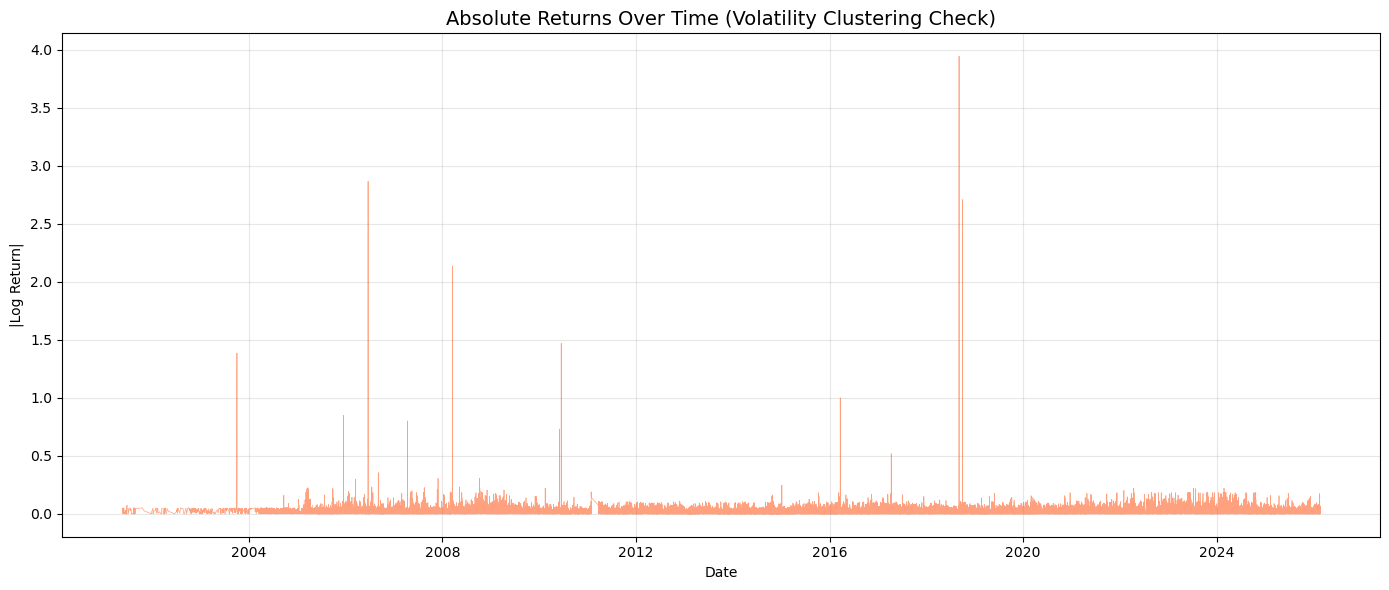

In [84]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['abs_return'], color='orangered', alpha=0.5, linewidth=0.5)
plt.title('Absolute Returns Over Time (Volatility Clustering Check)', fontsize=14)
plt.ylabel('|Log Return|')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

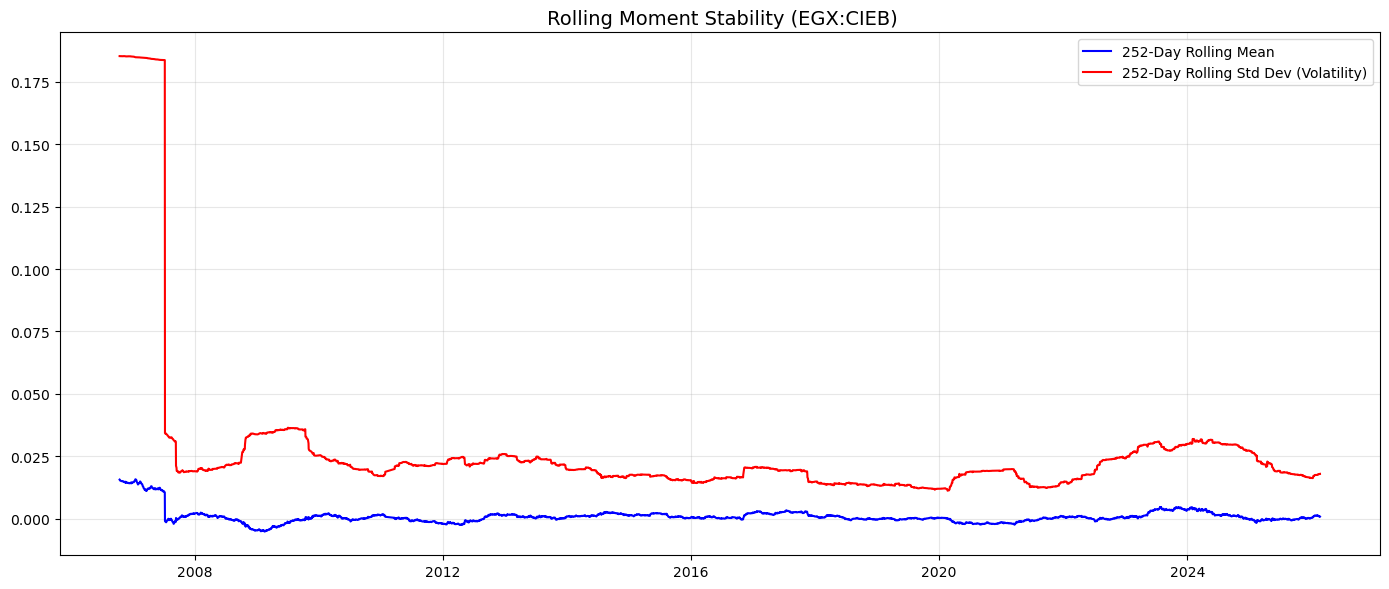

In [86]:
# Calculate rolling stats for a representative stock or the whole group
rolling_window = 252
# Using the first symbol as a representative case
sample_sym = df['symbol'].unique()[0]
sample_df = df[df['symbol'] == sample_sym]

plt.figure(figsize=(14, 6))
plt.plot(sample_df['date'], sample_df['log_return'].rolling(rolling_window).mean(), 
        label='252-Day Rolling Mean', color='blue')
plt.plot(sample_df['date'], sample_df['log_return'].rolling(rolling_window).std(), 
        label='252-Day Rolling Std Dev (Volatility)', color='red')

plt.title(f' Rolling Moment Stability ({sample_sym})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

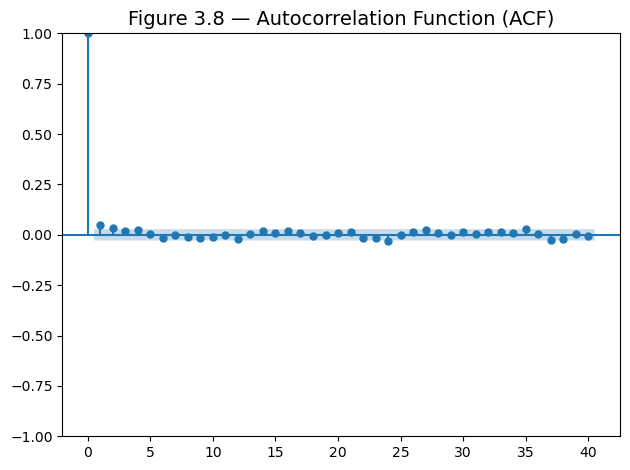

In [87]:
# Observing the most liquid stock (e.g., first in list)
plt.figure(figsize=(10, 6))
plot_acf(df[df['symbol'] == df['symbol'].unique()[0]]['log_return'].dropna(), 
        lags=40, alpha=0.05)
plt.title('Figure 3.8 — Autocorrelation Function (ACF)', fontsize=14)
plt.tight_layout()
plt.show()

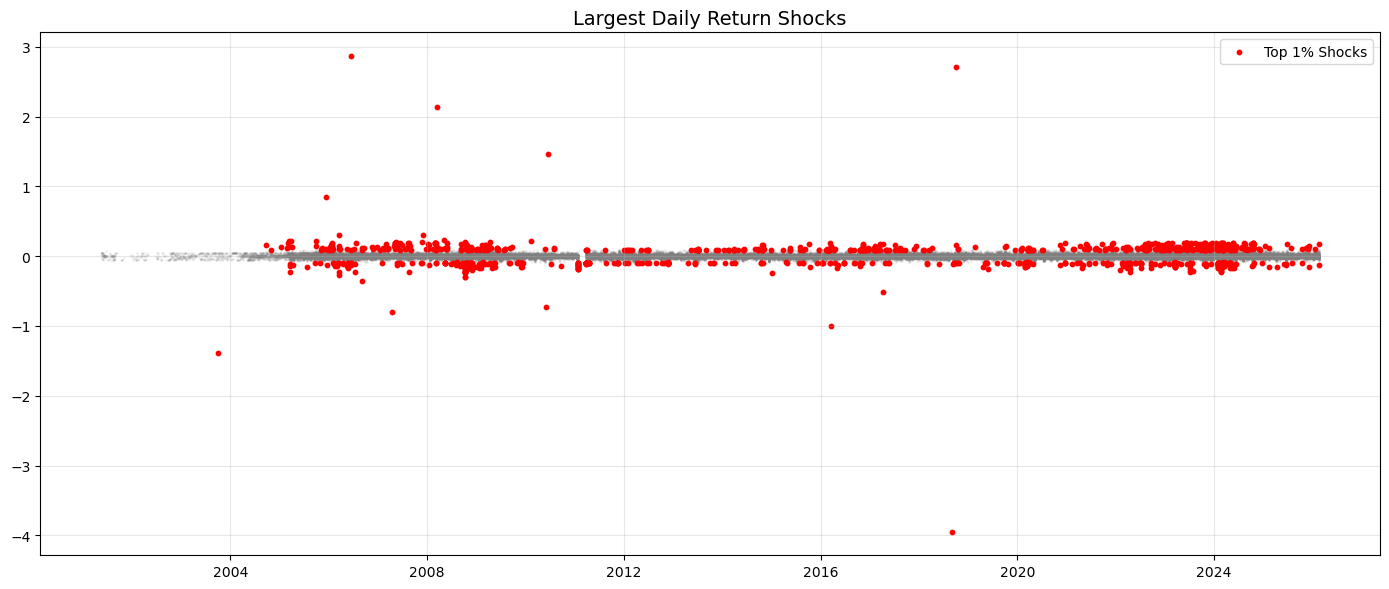

In [89]:
# Identify top 1% of absolute moves
threshold = df['abs_return'].quantile(0.99)
shocks = df[df['abs_return'] > threshold]

plt.figure(figsize=(14, 6))
plt.scatter(df['date'], df['log_return'], color='gray', alpha=0.1, s=1)
plt.scatter(shocks['date'], shocks['log_return'], color='red', s=10, label='Top 1% Shocks')
plt.title('Largest Daily Return Shocks', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

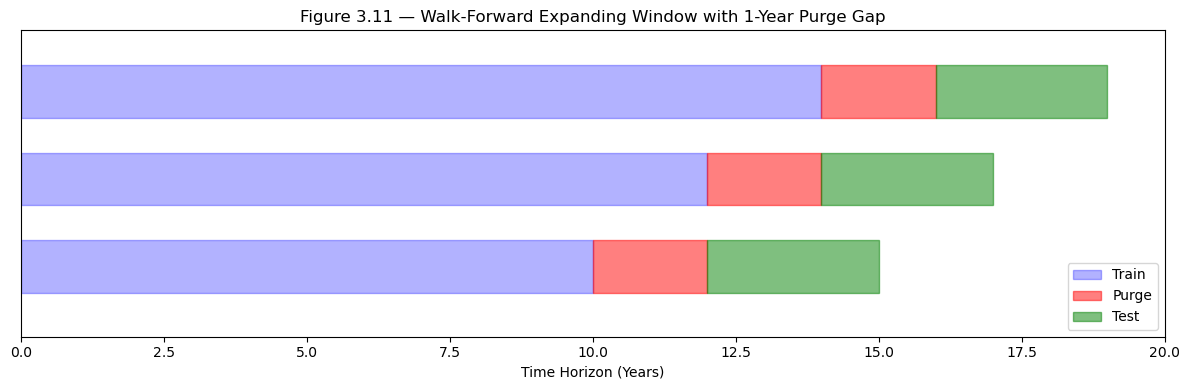

In [90]:

from matplotlib import patches


fig, ax = plt.subplots(figsize=(12, 4))
# Simulating 3 folds
for i in range(3):
    ax.add_patch(patches.Rectangle((0, i), 10 + i*2, 0.6, color='blue', alpha=0.3, label='Train' if i==0 else ""))
    ax.add_patch(patches.Rectangle((10 + i*2, i), 2, 0.6, color='red', alpha=0.5, label='Purge' if i==0 else ""))
    ax.add_patch(patches.Rectangle((12 + i*2, i), 3, 0.6, color='green', alpha=0.5, label='Test' if i==0 else ""))

ax.set_xlim(0, 20)
ax.set_ylim(-0.5, 3)
ax.set_title('Figure 3.11 — Walk-Forward Expanding Window with 1-Year Purge Gap')
ax.set_xlabel('Time Horizon (Years)')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

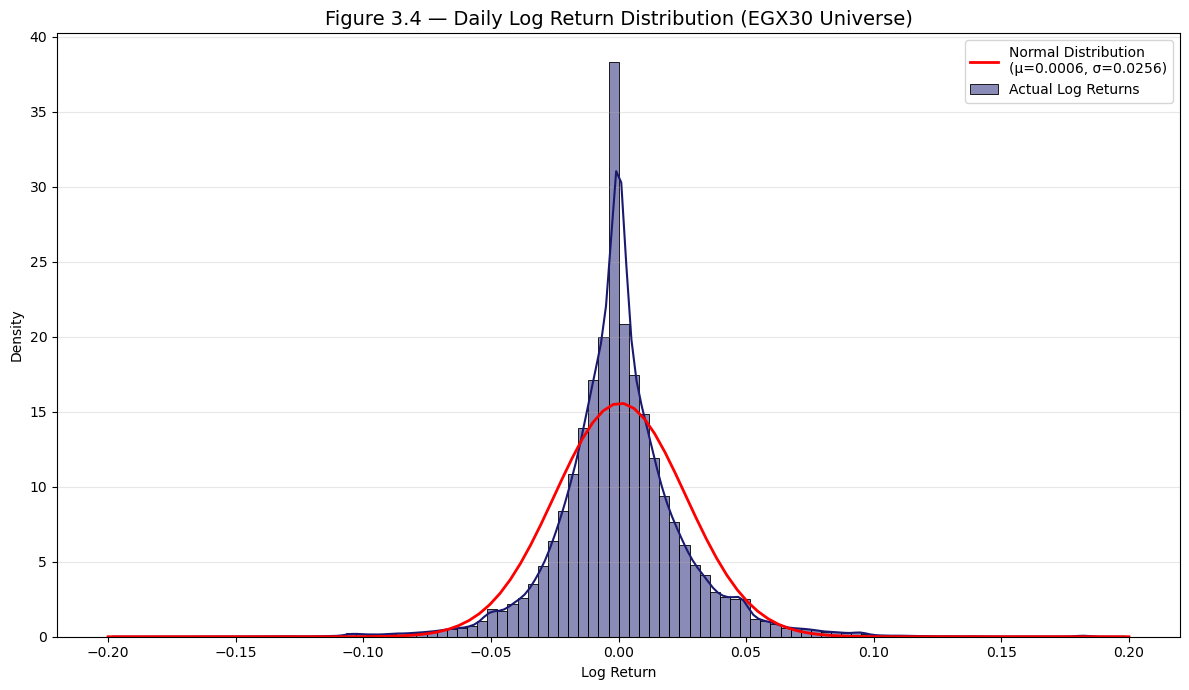

In [91]:


# 1. Prepare the data (drop NaNs from the log_return column)
# We focus on the range -0.2 to 0.2 to keep the visualization clean
returns_data = df['log_return'].dropna()
filtered_data = returns_data[returns_data.between(-0.2, 0.2)]

# 2. Plotting
plt.figure(figsize=(12, 7))

# Histogram with KDE
sns.histplot(filtered_data, bins=100, kde=True, color='midnightblue', 
        stat="density", label='Actual Log Returns')

# Overlay a Normal Distribution Curve for comparison
mu, std = filtered_data.mean(), filtered_data.std()
x = np.linspace(-0.2, 0.2, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n(μ={mu:.4f}, σ={std:.4f})')

# Formatting
plt.title('Figure 3.4 — Daily Log Return Distribution (EGX30 Universe)', fontsize=14)
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot 1: EGX30 Universe Coverage by Year
# This bar chart shows the number of unique companies in the EGX30 index each year from 2001 to 2026, with a target line at 30 stocks.
coverage = df.groupby(df['date'].dt.year)['symbol'].nunique()
plt.figure(figsize=(12, 6))
coverage.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('EGX30 Universe Coverage (2001–2026)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Unique Companies', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=30, color='red', linestyle='--', label='Target (30 Stocks)')
plt.legend()
plt.show()

In [ ]:
# Plot 2: Close Price Time Series with Rolling Statistics
# This plot displays the close price over time, along with 252-day rolling mean and standard deviation to check for stationarity and trends.
# Ensure numeric types
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Calculating Returns
df['returns'] = np.log(df['close'] / df['close'].shift(1))

# Visualization Setup
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

# Plot 1: Price Analysis (Trend & Seasonality)
axes[0].plot(df.index, df['close'], color='#1f77b4', lw=0.8)
axes[0].set_title('Financial Time Series: Close Price', fontsize=14)
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

# Plot 2: Returns Analysis (Volatility Clustering)
axes[1].plot(df.index, df['returns'], color='#ff7f0e', lw=0.5, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='--', lw=1)
axes[1].set_title('Log Returns: Volatility Clustering Check', fontsize=14)
axes[1].set_ylabel('Log Returns')
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling Statistics (Stationarity Check)
window = 252
rolling_mean = df['close'].rolling(window=window).mean()
rolling_std = df['close'].rolling(window=window).std()

axes[2].plot(df.index, df['close'], color='gray', alpha=0.2, label='Original')
axes[2].plot(rolling_mean.index, rolling_mean, color='red', lw=2, label='Rolling Mean (1Y)')
axes[2].plot(rolling_std.index, rolling_std, color='black', lw=1.2, label='Rolling Std (1Y)')
axes[2].set_title('Rolling Mean & Standard Deviation', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot 3: Mean Reversion Check with Moving Average
# Plot of close price vs 20-day moving average, with colored areas showing deviations.
df['ma20'] = df['close'].rolling(window=20).mean()
plt.figure(figsize=(14, 7))
plt.plot(df['close'], label='Close Price', alpha=0.7)
plt.plot(df['ma20'], label='20-Day MA', linestyle='--')
plt.fill_between(df.index, df['close'], df['ma20'], where=(df['close'] > df['ma20']), color='green', alpha=0.1)
plt.fill_between(df.index, df['close'], df['ma20'], where=(df['close'] < df['ma20']), color='red', alpha=0.1)
plt.title('Mean Reversion Check with 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Plot 4: Log Returns Distribution Histogram
# Histogram with KDE showing the distribution of log returns.
plt.figure(figsize=(12, 6))
sns.histplot(df['returns'].dropna(), kde=True, color='blue', stat="density")
plt.title('Log Returns Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.show()

In [ ]:
# Plot 5: Q-Q Plot for Normality Check
# Q-Q plot comparing log returns to normal distribution.
plt.figure(figsize=(8, 6))
stats.probplot(df['returns'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality Check')
plt.show()

In [ ]:
# Plot 6: Autocorrelation Function of Log Returns
# ACF plot showing autocorrelation up to 30 lags.
plot_acf(df['returns'].dropna(), lags=30)
plt.title('Autocorrelation Function of Log Returns')
plt.show()

In [ ]:
# Plot 7: Autocorrelation Function for Momentum Check
# ACF plot to check for momentum in log returns.
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
plt.figure(figsize=(12, 6))
plot_acf(df['log_returns'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (Momentum Check)')
plt.show()

In [ ]:
# Plot 8: Price History for Sample Stock (EGX:COMI)
# Time series plot of close price for a sample stock to check for adjustments or splits.
sample_stock = "EGX:COMI"
stock_df = df[df['symbol'] == sample_stock]
plt.figure(figsize=(12, 6))
plt.plot(stock_df['date'], stock_df['close'])
plt.title(f"Price History for {sample_stock} (Unadjusted)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [ ]:
# Plot 9: Observations per Company
# Bar chart showing the number of trading days per company symbol.
counts = df.groupby('symbol').size().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.title("Number of Observations per Company")
plt.ylabel("Count of Trading Days")
plt.xlabel("Symbol")
plt.show()

In [ ]:
# Plot 10: Pooled Daily Return Distribution
# Histogram with KDE and normal distribution overlay for daily returns.
from scipy.stats import norm
df['daily_return'] = df.groupby('symbol')['close'].pct_change()
plot_data = df['daily_return'].dropna()
plot_data = plot_data[plot_data.between(-0.2, 0.2)]
plt.figure(figsize=(12, 6))
sns.histplot(plot_data, bins=100, kde=True, color='navy', stat="density", label='Actual Returns')
mu, std = plot_data.mean(), plot_data.std()
x = np.linspace(-0.2, 0.2, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution (Theoretical)')
plt.title('Pooled Daily Return Distribution (EGX30 Universe)', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Plot 11: Log Returns Over Time
# Time series plot of log returns to check for volatility clustering.
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['log_return'], color='teal', alpha=0.4, linewidth=0.5)
plt.title('Log Returns Over Time (Volatility Clustering Check)', fontsize=14)
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()